# Using projectile motion data, let's predict what initial velocity is required when firing at a given angle to reach the intended target distance.

## 1. Import Dependencies and Read Data into Dataframe

In [822]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import torch
from torch import nn
import plotly.express as px
from tqdm import tqdm
import os

In [823]:
os.getcwd()

'/content/drive/MyDrive/Projects/Python/projectile_motion'

In [824]:
# check if running in google colab
try:
    import google.colab
    from google.colab import drive
    # IN_COLAB = True
    # mount google drive
    drive.mount('/content/drive')
    # Set the working directory
    os.chdir('/content/drive/MyDrive/Projects/Python/projectile_motion')
    # make device agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f'Running in Google Colab with device: {device}')
except ModuleNotFoundError:
    # IN_COLAB = False
    device = torch.device("mps")
    # device = torch.device("cpu")
    print(f'Running Locally with device: {device}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Running in Google Colab with device: cpu


In [825]:
# filepath to pickle data file
# path = 'data/results_small.pkl'
# path = 'data/results_mid.pkl'
path = 'data/results_rand_1000.pkl'
# path = 'data/results_large.pkl'

try:
  with open(path, 'rb') as file:
    # load results list from pickle
    results = pickle.load(file)
    print('Pickle file loaded.')
except FileNotFoundError:
  print('Pickle file not found!')

Pickle file loaded.


In [826]:
# create df from dictionaries in list and view first 5 entries
input_df = pd.DataFrame(results)
input_df.head()

,vel_start,angle,distance
0,0.962451,0.200149,1.924891
1,3.693698,0.204666,7.387349
2,0.306314,0.867718,0.612558
3,0.581955,0.145350,1.163905
4,0.005090,43.872724,0.007338


In [827]:
# save data to csv
input_df.to_csv('input_data.csv')

In [828]:
# sort by distance
input_df = input_df.sort_values(by='distance').reset_index(drop=True)
input_df.head()

,vel_start,angle,distance
0,0.001289,52.352440,0.001575
1,0.005090,43.872724,0.007338
2,0.007521,7.666638,0.014908
3,0.009725,21.237456,0.018129
4,1.134938,89.978315,0.024914


## 2 Visualize

In [829]:
# create scatterplot
fig = px.scatter_3d(input_df, x='vel_start', y='angle', z='distance',
                    # color=df['distance'].apply(lambda x: 'white' if target - threshold <= x <= target + threshold else 'blue'),
                    labels={'vel_start': 'Velocity Start', 'angle': 'Angle', 'distance': 'Distance'})

fig.update_traces(marker_size=2)

# Show the interactive plot
fig.show()

## 3. Convert Data To Tensors

### 3.1 Normalize DataFrame Values
Neural networks work better with tensors on the same scale [0, 1]

In [830]:
def normalize_df_to_tensors(df):
  '''Normalized values to range [0, 1] and returns as X, y tensors as well as dict of scaling factors.'''
  # create new column for the max value of each variable
  df['max_angle'] = df['angle'].max()
  df['max_distance'] = df['distance'].max()
  df['max_vel_start'] = df['vel_start'].max()

  # divide each column by the largest value in each column, so they ranges [0, 1] and save to new columns
  df['angle_norm'] = df['angle'] / df['max_angle']
  df['distance_norm'] = df['distance'] / df['max_distance']
  df['vel_start_norm'] = df['vel_start'] / df['max_vel_start']

  # check value range again to make sure they range [0, 1]
  print(f"Non-normalized max values: Angle: {df['angle'].max()}, Dist: {df['distance'].max()}, Vel: {df['vel_start'].max()}")
  print(f"Normalized max values: Angle: {df['angle_norm'].max()}, Dist: {df['distance_norm'].max()}, Vel: {df['vel_start_norm'].max()}")

  # extract values from normalized df
  X_values = df[['angle_norm', 'distance_norm']].values
  y_values = df['vel_start_norm'].values

  # convert to tensors
  X = torch.tensor(X_values, dtype=torch.float32)
  y = torch.tensor(y_values, dtype=torch.float32).unsqueeze(dim=1)

  return X, y, df

In [831]:
input_df.head()

,vel_start,angle,distance
0,0.001289,52.352440,0.001575
1,0.005090,43.872724,0.007338
2,0.007521,7.666638,0.014908
3,0.009725,21.237456,0.018129
4,1.134938,89.978315,0.024914


In [832]:
# convert dataframe to tensors
X, y, normalized_df = normalize_df_to_tensors(input_df)

Non-normalized max values: Angle: 89.97831473697605, Dist: 388.7588524011709, Vel: 3.9995145777678025
Normalized max values: Angle: 1.0, Dist: 1.0, Vel: 1.0


In [833]:
input_df.head()

,vel_start,angle,distance,max_angle,max_distance,max_vel_start,angle_norm,distance_norm,vel_start_norm
0,0.001289,52.352440,0.001575,89.978315,388.758852,3.999515,0.581834,0.000004,0.000322
1,0.005090,43.872724,0.007338,89.978315,388.758852,3.999515,0.487592,0.000019,0.001273
2,0.007521,7.666638,0.014908,89.978315,388.758852,3.999515,0.085205,0.000038,0.001881
3,0.009725,21.237456,0.018129,89.978315,388.758852,3.999515,0.236029,0.000047,0.002432
4,1.134938,89.978315,0.024914,89.978315,388.758852,3.999515,1.000000,0.000064,0.283769


In [834]:
# check tensor length
len(X), len(y)

(1000, 1000)

In [835]:
# check tensor size
X.size(), y.size()

(torch.Size([1000, 2]), torch.Size([1000, 1]))

In [836]:
# check first values
X[0], y[0]

(tensor([5.8183e-01, 4.0508e-06]), tensor([0.0003]))

In [837]:
# check first value shapes
X[0].shape, y[0].shape

(torch.Size([2]), torch.Size([1]))

In [838]:
# check first value number of dimensions
print(f'X has {X[0].ndim} dimensions | y has {y[0].ndim} dimensions')

X has 1 dimensions | y has 1 dimensions


In [839]:
# # y shape is a scalar, so we should unsqueeze it so it will match model output
# y = y.unsqueeze(dim=1)
# y[0], y[0].shape

In [840]:
# # check first value number of dimensions
# print(f'X has {X[0].ndim} dimensions | y has {y[0].ndim} dimensions')

In [841]:
# check first 5 tensor values
X[:5], y[:5]

(tensor([[5.8183e-01, 4.0508e-06],
         [4.8759e-01, 1.8876e-05],
         [8.5205e-02, 3.8349e-05],
         [2.3603e-01, 4.6634e-05],
         [1.0000e+00, 6.4086e-05]]),
 tensor([[0.0003],
         [0.0013],
         [0.0019],
         [0.0024],
         [0.2838]]))

In [842]:
def denormalize_tensors_to_df(df, X: torch.Tensor, y: torch.Tensor, pred: torch.Tensor=None) -> pd.DataFrame:
  '''Convert tensor values back to their original scale and save to dataframe. X[angle, distance] y[velocity]'''
  # multiply by scale factor and convert to numpy arrays
  angle_np = (X[:, 0] * df.max_angle[0]).to('cpu').numpy()
  distance_np = (X[:, 1] * df.max_distance[0]).to('cpu').numpy()
  vel_start_np = (y * df.max_vel_start[0]).to('cpu').numpy().squeeze()

  # create df for denormalized values
  denorm_df = pd.DataFrame(data={'vel_start': vel_start_np, 'angle': angle_np, 'distance': distance_np})

  # if prediction is provided
  if pred is not None:
    # denormalize
    prediction_np = (pred * df.max_vel_start[0]).to('cpu').numpy().squeeze()
    # add to the df
    denorm_df['vel_preds'] = prediction_np

  return denorm_df

In [843]:
# denormalize tensors
denorm_df = denormalize_tensors_to_df(input_df, X, y)
denorm_df.head()

,vel_start,angle,distance
0,0.001289,52.352440,0.001575
1,0.005090,43.872726,0.007338
2,0.007521,7.666638,0.014908
3,0.009725,21.237457,0.018129
4,1.134938,89.978317,0.024914


In [844]:
# compare to original df
input_df.head()

,vel_start,angle,distance,max_angle,max_distance,max_vel_start,angle_norm,distance_norm,vel_start_norm
0,0.001289,52.352440,0.001575,89.978315,388.758852,3.999515,0.581834,0.000004,0.000322
1,0.005090,43.872724,0.007338,89.978315,388.758852,3.999515,0.487592,0.000019,0.001273
2,0.007521,7.666638,0.014908,89.978315,388.758852,3.999515,0.085205,0.000038,0.001881
3,0.009725,21.237456,0.018129,89.978315,388.758852,3.999515,0.236029,0.000047,0.002432
4,1.134938,89.978315,0.024914,89.978315,388.758852,3.999515,1.000000,0.000064,0.283769


### 3.2 Create Train / Test Split

In [845]:
# combine X and y into a tuple so they stay grouped together
dataset = torch.utils.data.TensorDataset(X, y)

In [846]:
# check that first value tensor matches df
dataset[0], input_df.head(1)

((tensor([5.8183e-01, 4.0508e-06]), tensor([0.0003])),
    vel_start     angle  distance  max_angle  max_distance  max_vel_start  \
 0   0.001289  52.35244  0.001575  89.978315    388.758852       3.999515   
 
    angle_norm  distance_norm  vel_start_norm  
 0    0.581834       0.000004        0.000322  )

In [847]:
# set size of train and test stes
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

In [848]:
# create train and test datasets
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
len(train_dataset), len(test_dataset)

(800, 200)

## 4. Build a Model

In [849]:
# try a simple model
class RegressionModelV0(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    # initialize parent class nn.Module
    super().__init__()
    # create linear layer to feed the two X values into (angle, distance)
    self.layer1 = nn.Linear(input_size, hidden_size)
    # create nonlinear activation function
    self.relu = nn.ReLU()
    # create second linear layer to feed the hidden layers into the output
    self.layer2 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = self.layer1(x)
    x = self.relu(x)
    x = self.layer2(x)
    return x

In [850]:
# set manual seed for reproducibility
torch.manual_seed(57)
# create instance of model 0
model_0 = RegressionModelV0(input_size=2, hidden_size=20, output_size=1).to(device)

In [851]:
# define a loss function (mean squared error)
loss_fn = nn.MSELoss()
# choose optimiser
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

## 5. Make Predictions with Untrained Model

### 5.1 Try feeding first data point through model to get prediction

In [852]:
# get a sample for the testing data
X_sample, y_sample = dataset[0]
# put sample on device
X_sample, y_sample = X_sample.to(device), y_sample.to(device)
X_sample, y_sample

(tensor([5.8183e-01, 4.0508e-06]), tensor([0.0003]))

In [853]:
# set model to evaluation (no learning) mode
model_0.eval()

RegressionModelV0(
  (layer1): Linear(in_features=2, out_features=20, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=20, out_features=1, bias=True)
)

In [854]:
# turn off gradient tracking (which is only used for learning)
with torch.no_grad():
  # make a prediction
  predicted_y = model_0(X_sample)

In [855]:
# see the predicted value and true vales
print(f'The untrained model predicted normalzed {y_sample.item()} and the true value was {predicted_y.item()}')

The untrained model predicted normalzed 0.0003223177045583725 and the true value was -0.45733892917633057


This makes sense since the model has not been trained.

In [856]:
# check shape of true y and predicted y
y_sample.shape, predicted_y.shape

(torch.Size([1]), torch.Size([1]))

In [857]:
y_sample.ndim, predicted_y.ndim

(1, 1)

In [858]:
# calculate test loss
loss_sample = loss_fn(predicted_y, y_sample)
loss_sample

tensor(0.2095)

In [859]:
# check the sample X and its shape
X_sample, X_sample.shape

(tensor([5.8183e-01, 4.0508e-06]), torch.Size([2]))

In [860]:
# add dimension to individual X sample to match tensor of a batch of many sample values which we will usually use
X_sample = X_sample.unsqueeze(dim=0)
X_sample.shape

torch.Size([1, 2])

In [861]:
# denormalize sample to df and check normalization -> denormalization results in original value
denorm_sample_df = denormalize_tensors_to_df(input_df, X_sample, y_sample, predicted_y)
print('Input df')
print(input_df.head(1))
print('\nModel Prediction')
print(denorm_sample_df.head(1))

Input df
   vel_start     angle  distance  max_angle  max_distance  max_vel_start  \
0   0.001289  52.35244  0.001575  89.978315    388.758852       3.999515   

   angle_norm  distance_norm  vel_start_norm  
0    0.581834       0.000004        0.000322  

Model Prediction
   vel_start     angle  distance  vel_preds
0   0.001289  52.35244  0.001575  -1.829134


### 5.2 Predict Entire Test Dataset

In [862]:
def predict_all_test(test_dataset, model, input_df, loss_fn):
    # create list to store results dfs
    results_df_list = []
    # create variable to track loss
    test_loss = 0
    # iterate over all samples in test dataset
    for sample in tqdm(test_dataset):
      # extract X and y
      X_sample, y_sample = sample
      # put sample on target device
      X_sample, y_sample = X_sample.to(device), y_sample.to(device)
      # set model to eval mode
      model.eval()
      # turn off gradient tracking
      with torch.no_grad():
        # predict
        predicted_y = model(X_sample)
        # calculate loss and add to running todal
        test_loss += loss_fn(predicted_y, y_sample)
        # add dimension to X
        X_sample = X_sample.unsqueeze(dim=0)
        # denormalize result and save to df
        denorm_sample_df = denormalize_tensors_to_df(input_df, X_sample, y_sample, predicted_y)
        # append individual sample df to list
        results_df_list.append(denorm_sample_df)
    # concatenate list of results dataframes
    test_pred_df = pd.concat(results_df_list, axis=0, ignore_index=True)
    # divide accumulated loss by num of items
    test_loss /= len(test_dataset)

    return test_pred_df, test_loss.item()

In [863]:
# predict entire test data with current model
test_preds_df, test_loss = predict_all_test(test_dataset, model_0, input_df, loss_fn)
test_preds_df.head()

100%|██████████| 200/200 [00:00<00:00, 844.00it/s]


,vel_start,angle,distance,vel_preds
0,2.146619,38.566742,114.131477,-1.361141
1,2.941353,32.427578,198.616577,-1.035835
2,2.551119,58.385567,147.102753,-1.385190
3,1.954152,63.471836,77.679016,-1.640991
4,3.312126,13.946799,131.793869,-1.171868


In [864]:
print(f'Model 0 with no training test loss: {test_loss}')

Model 0 with no training test loss: 0.8978873491287231


In [865]:
# check min and max velocity values
test_preds_df.vel_start.min(), test_preds_df.vel_start.max()

(0.005089771, 3.9944184)

In [866]:
# check min and max predicted values
test_preds_df.vel_preds.min(), test_preds_df.vel_preds.max()

(-2.0925138, -0.555561)

In [867]:
import plotly.express as px

def plot_results(input_df, train_dataset, test_dataset, test_preds_df):
    # Denormalize datasets to DataFrame
    train_df = denormalize_tensors_to_df(input_df, train_dataset[:][0], train_dataset[:][1])
    test_df = denormalize_tensors_to_df(input_df, test_dataset[:][0], test_dataset[:][1])

    marker_size = 1

    # Create scatter plot for train data in blue
    fig_train = px.scatter_3d(train_df, x='vel_start', y='angle', z='distance',
                              labels={'vel_start': 'Velocity Start', 'angle': 'Angle', 'distance': 'Distance'},
                              title='Train Data', size_max=marker_size)
    # Update marker size for test data
    fig_train.update_traces(marker=dict(size=marker_size))

    # Create scatter plot for test data in green
    fig_test = px.scatter_3d(test_df, x='vel_start', y='angle', z='distance',
                             color_discrete_sequence=['green'],
                             title='Test Data')

    # Update marker size for test data
    fig_test.update_traces(marker=dict(size=marker_size))

    # Create scatter plot for predictions in red
    fig_preds = px.scatter_3d(test_preds_df, x='vel_preds', y='angle', z='distance',
                              color_discrete_sequence=['red'],
                              title='Predictions')

    # Update marker size for predictions
    fig_preds.update_traces(marker=dict(size=marker_size * 2))

    # Combine the plots
    fig = px.scatter_3d(title='Train / Test / Predictions', size_max=marker_size)
    fig.add_trace(fig_train.data[0])
    fig.add_trace(fig_test.data[0])
    fig.add_trace(fig_preds.data[0])

    # Show the interactive plot
    fig.show()

# Call the function with your datasets
plot_results(input_df, train_dataset, test_dataset, test_preds_df)

## 6. Training

In [868]:
train_dataset[0]

(tensor([0.5772, 0.1761]), tensor([0.4145]))

In [869]:
# check model device
next(model_0.parameters()).device

device(type='cpu')

In [870]:
%%time
torch.manual_seed(42)

epochs = 100

epoch_count = []
loss_values = []
test_loss_values = []

# extract train and test sets
X_train, y_train = train_dataset[:]
X_test, y_test = test_dataset[:]

# put train and test sets on device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# iterate over range of epochs
for epoch in range(epochs):
  ### Train
  model_0.train()
  # forward pass
  y_pred = model_0(X_train)
  # calculate loss
  loss = loss_fn(y_pred, y_train)
  # optimizer zero grade
  optimizer.zero_grad()
  # backpropagation
  loss.backward()
  # step
  optimizer.step()

  ### Test
  model_0.eval()
  # turn off gradient tracking
  with torch.inference_mode():
    # forward pass
    test_pred = model_0(X_test)
    # calculate loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch % (epochs / 10) == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f'Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}')

Epoch: 0 | Loss: 0.8578609228134155 | Test Loss: 0.8788232207298279
Epoch: 10 | Loss: 0.6853024363517761 | Test Loss: 0.7032220959663391
Epoch: 20 | Loss: 0.5402651429176331 | Test Loss: 0.5558390617370605
Epoch: 30 | Loss: 0.42210865020751953 | Test Loss: 0.43567782640457153
Epoch: 40 | Loss: 0.3279721140861511 | Test Loss: 0.33982688188552856
Epoch: 50 | Loss: 0.2541328966617584 | Test Loss: 0.26448681950569153
Epoch: 60 | Loss: 0.1970130205154419 | Test Loss: 0.20595774054527283
Epoch: 70 | Loss: 0.1534471958875656 | Test Loss: 0.16109657287597656
Epoch: 80 | Loss: 0.12072882056236267 | Test Loss: 0.12718914449214935
Epoch: 90 | Loss: 0.09663442522287369 | Test Loss: 0.10198910534381866
CPU times: user 128 ms, sys: 4.95 ms, total: 133 ms
Wall time: 141 ms


In [871]:
# predict entire test data with current model
test_preds_df, test_loss = predict_all_test(test_dataset, model_0, input_df, loss_fn)
print(f'Test loss = {test_loss}')
# plot test data
plot_results(input_df, train_dataset, test_dataset, test_preds_df)

100%|██████████| 200/200 [00:00<00:00, 886.31it/s]


Test loss = 0.08521709591150284


## 7. Try with Scikit Learn

In [872]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Create a 3D scatter plot
fig = px.scatter_3d(
    input_df, x='angle', y='distance', z='vel_start',
    labels={'angle': 'Angle', 'distance': 'Distance', 'vel_start': 'Vel_start'},
    title='3D Scatter Plot',
    size_max=2,  # Adjust the maximum marker size
    opacity=0.6  # Adjust the marker opacity
)

fig.update_traces(marker_size=2)

# Fit a polynomial regression model
poly_model = make_pipeline(
    PolynomialFeatures(degree=3),
    LinearRegression()
)

# Extract features and target
X = input_df[['angle', 'distance']]
y = input_df['vel_start']

# Fit the model
poly_model.fit(X, y)

# Create a meshgrid for the surface plot
angle_surf, distance_surf = np.meshgrid(
    np.linspace(input_df['angle'].min(), input_df['angle'].max(), 100),
    np.linspace(input_df['distance'].min(), input_df['distance'].max(), 100)
)

surface_data = np.column_stack((angle_surf.ravel(), distance_surf.ravel()))

# Predict the values for the surface plot
vel_start_surf = poly_model.predict(surface_data)
vel_start_surf = vel_start_surf.reshape(angle_surf.shape)

# Add surface plot to the existing 3D scatter plot
fig.add_trace(go.Surface(x=angle_surf, y=distance_surf, z=vel_start_surf, opacity=0.7))

# Show the interactive plot
fig.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but PolynomialFeatures was fitted with feature names



In [873]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Fit a polynomial regression model on the training dataset
poly_model = make_pipeline(
    PolynomialFeatures(degree=3),
    LinearRegression()
)

# Extract features and target from the training dataset
X_train_np = train_dataset[:][0].numpy()  # Assuming the first element of the training dataset contains features
y_train_np = train_dataset[:][1].numpy()  # Assuming the second element of the training dataset contains target values

# Fit the model
poly_model.fit(X_train_np, y_train_np)

# Use x-values from the test dataset to create a DataFrame of results
X_test_np = test_dataset[:][0].numpy()  # Assuming the first element of the test dataset contains features

# Predict the y-values for the test dataset
y_test_pred_np = poly_model.predict(X_test_np)

# convert test predictions back to tensor
y_test_pred_tensor = torch.from_numpy(y_test_pred_np)

# create dataframe of results
poly_results_df = denormalize_tensors_to_df(input_df, X_test, y_test, y_test_pred_tensor)
# plot test data
plot_results(input_df, train_dataset, test_dataset, poly_results_df)

# Display the results DataFrame
poly_results_df.head()

,vel_start,angle,distance,vel_preds
0,2.146619,38.566742,114.131477,2.212808
1,2.941353,32.427578,198.616577,2.937154
2,2.551119,58.385567,147.102753,2.635538
3,1.954152,63.471836,77.679016,2.047641
4,3.312126,13.946799,131.793869,3.558694


In [875]:
from sklearn.metrics import mean_squared_error

# Assuming poly_results_df is your DataFrame
y_true = poly_results_df['vel_start']
y_pred = poly_results_df['vel_preds']

mse = mean_squared_error(y_true, y_pred)

print(f'Mean Squared Error: {mse}')


Mean Squared Error: 0.08771326392889023


Mean Squared Error on Test Set: 1.5380415805886627
Mean Absolute Error on Test Set: 0.9092670398176912
R-squared on Test Set: -0.22132626121480525
Explained Variance Score on Test Set: -0.21585054768036116


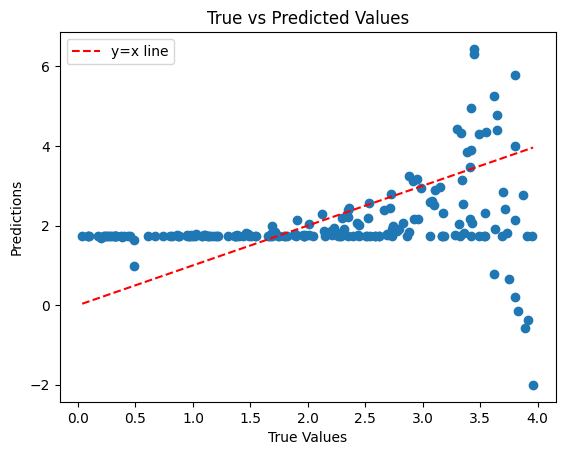

In [881]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# Generate some example data
np.random.seed(42)

# Split the data into features (X) and target variable (y)
X = input_df[['angle', 'distance']]
y = input_df['vel_start']

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a polynomial regression model
model = make_pipeline(
    PolynomialFeatures(degree=20),
    LinearRegression()
)

model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)

# Print evaluation metrics
print(f'Mean Squared Error on Test Set: {mse}')
print(f'Mean Absolute Error on Test Set: {mae}')
print(f'R-squared on Test Set: {r2}')
print(f'Explained Variance Score on Test Set: {explained_var}')

# Plot the true vs predicted values
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='y=x line')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()


In [883]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# Generate some example data
np.random.seed(42)

# Split the data into features (X) and target variable (y)
X = input_df[['angle', 'distance']]
y = input_df['vel_start']

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for degree in range(20):
  # Train a polynomial regression model
  model = make_pipeline(
      PolynomialFeatures(degree=degree),
      LinearRegression()
  )

  model.fit(X_train, y_train)

  # Predict on the test set
  y_pred = model.predict(X_test)

  # Evaluate the model performance
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  explained_var = explained_variance_score(y_test, y_pred)

  # Print evaluation metrics
  print(f'{degree} degree. Mean Squared Error on Test Set: {mse}\n')
  # print(f'Mean Absolute Error on Test Set: {mae}')
  # print(f'R-squared on Test Set: {r2}')
  # print(f'Explained Variance Score on Test Set: {explained_var}')

0 degree. Mean Squared Error on Test Set: 1.2604176629866601

1 degree. Mean Squared Error on Test Set: 0.595997844058635

2 degree. Mean Squared Error on Test Set: 0.17968777708404812

3 degree. Mean Squared Error on Test Set: 0.17348781087891826

4 degree. Mean Squared Error on Test Set: 0.09989652703795007

5 degree. Mean Squared Error on Test Set: 0.09616575468308036

6 degree. Mean Squared Error on Test Set: 0.074303281967751

7 degree. Mean Squared Error on Test Set: 0.160490974673699

8 degree. Mean Squared Error on Test Set: 18.198358184591154

9 degree. Mean Squared Error on Test Set: 0.321196333678061

10 degree. Mean Squared Error on Test Set: 0.6129889893193047

11 degree. Mean Squared Error on Test Set: 0.5545139899245028

12 degree. Mean Squared Error on Test Set: 0.47608297655016085

13 degree. Mean Squared Error on Test Set: 0.5965652497149101

14 degree. Mean Squared Error on Test Set: 0.5433429457110294

15 degree. Mean Squared Error on Test Set: 1.9251482656084955

1